In [19]:
import shadow_reconstruction
import qutip as qt
import numpy
from matplotlib import pyplot
import itertools
from tqdm.notebook import tqdm
import functools

In [2]:
def make_perms(n):
    return itertools.permutations(numpy.arange(n))

def permute_bits(i, n, perm):
    bits = bin(i)[2:]
    newbits = ''.join([bits[p] for p in perm])
    return int(newbits, 2)

def gen_cliffords():
    yield from qt.qubit_clifford_group()


def get_num_cons_cliffords():
    def f(x):
        y = numpy.eye(4, dtype=numpy.complex128)
        y[1:3, 1:3] = x
        return y
    return {
        k: f(v.__array__()) for k, v in enumerate(gen_cliffords())
    }
cliffords = numpy.array(list(get_num_cons_cliffords().values()))

/var/folders/xx/cyn56y8j4l198w4cbbcv3pp80000gn/T/ipykernel_89468/3648221067.py:10: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  yield from qt.qubit_clifford_group()


# Study Convergence

In [11]:
def uniform_rho(n):
    # (01 + 10)00
    zz = numpy.zeros((1, 1<<n), dtype=numpy.complex128)
    for j in range(n):
        zz[0, 1<<j] = 1.0
    rho = zz.T @ zz
    rho /= numpy.trace(rho)
    rho = shadow_reconstruction.DensityMatrix.from_dense(rho.astype(numpy.complex128))
    return rho

def half_filling_random(n, scale=1.0, phases=False):
    # (01 + 10)00
    zz = numpy.zeros((1, 1<<n), dtype=numpy.complex128)
    
    base_index = ['0']*(n//2) + ['1']*(n//2)
    for new_index in set(itertools.permutations(base_index)):
        new_index = int(''.join(new_index), 2)
        zz[0, new_index] = numpy.random.normal(scale=scale)
        if phases:
            zz[0,new_index] = zz[0,new_index] * numpy.exp(2.0j * numpy.pi * numpy.random.rand())
    
    rho = zz.T @ zz
    rho /= numpy.trace(rho)
    rho = shadow_reconstruction.DensityMatrix.from_dense(rho.astype(numpy.complex128))
    return rho


def make_samples(rho, n, iters=10000):
    exp = shadow_reconstruction.Experiment(n, ops=cliffords)
    return exp.sample(rho, iters)

def get_estimates(rho, n, opstring, samples, check=False):
    recon = shadow_reconstruction.Reconstruction(n, ops=cliffords)
    estimates = recon.estimate_string_for_each_sample(opstring, samples)
    if check:
        assert abs(estimates.mean() - recon.estimate_operator_string(opstring, samples)) < 1e-6
    return estimates

def get_exact(rho, opstring):
    return rho.expectation_string(opstring)

In [12]:
def get_diffs_for(opstring, L, iters, super_iters=100):
    means = []
    for _ in range(super_iters):
#         rho = uniform_rho(L)
        rho = half_filling_random(L, scale=0.1)
        exact = get_exact(rho, opstring)
        samples = make_samples(rho, L, iters=iters)
        expectation = get_estimates(rho, L, opstring, samples).mean()
        means.append(expectation)
    return numpy.array(means) - exact

In [13]:
def get_mean_sqr_for_Ls(Ls, iter_range=(1,10,2), super_iters=1000, opfn=None):
    if opfn is None:
        opfn = lambda l: '+-' + 'Z'*(l-2)
    s_iters = 2**numpy.arange(*iter_range)
    all_pairs = list(itertools.product(Ls, s_iters))
    numpy.random.shuffle(all_pairs)
    
    pair_data = {}
    for L, iters in tqdm(all_pairs):
        diffs = get_diffs_for(opfn(L), L, iters, super_iters=super_iters)
        # Calculate std of complex variables
        mean_sqr = numpy.sqrt((diffs * numpy.conj(diffs)).real.mean())
        pair_data[L,iters] = mean_sqr
    
    return s_iters, pair_data

  0%|          | 0/36 [00:00<?, ?it/s]

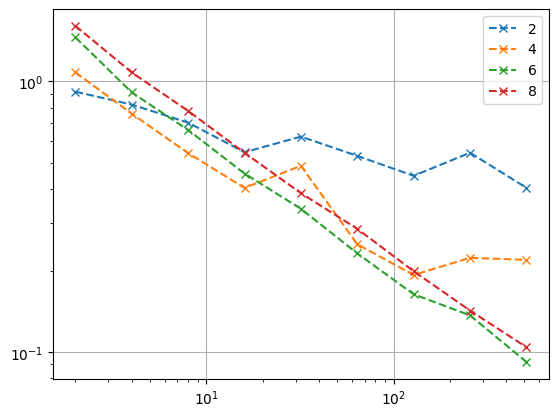

In [17]:
Ls = [2,4,6,8]
iter_range=(1,10,1)
s_iters, data = get_mean_sqr_for_Ls(Ls, iter_range=iter_range, opfn=lambda x: '+-'*(x//2))

for L in Ls:
    L_data = [data[(L,iters)] for iters in s_iters]
    pyplot.plot(s_iters, L_data, 'x--', label='{}'.format(L))
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.grid()
pyplot.legend()
pyplot.show()

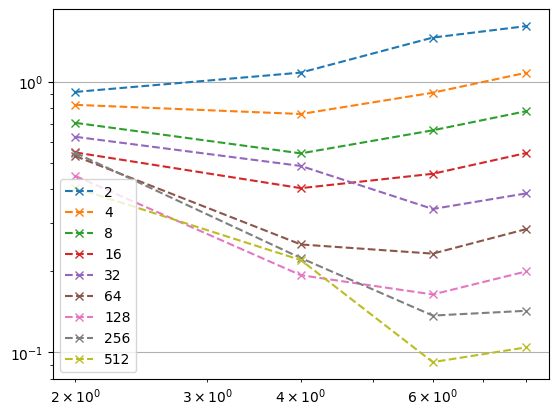

In [18]:
for iters in s_iters:
    L_data = [data[(L,iters)] for L in Ls]
    pyplot.plot(Ls, L_data, 'x--', label='{}'.format(iters))
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.grid()
pyplot.legend()
pyplot.show()